Project Proposal DSCI 100 Group 11

In [1]:
library(tidyverse)
library(dbplyr)
library(DBI)
library(purrr)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipe

Introduction: High stress levels among students can lead to a cascade of negative impacts, affecting their physical health, mental well-being, and academic performance. Understanding and addressing the root causes of this stress is crucial for creating a supportive and conducive learning environment that promotes both academic success and overall well-being. A public dataset reveals five key factors influencing a student's stress level:

Psychological factors: anxiety level, self esteem, mental health history, depression.
Physiological factors: headache, blood pressure, sleep quality, breathing problems.
Environmental factors: noise level, living conditions, safety, basic needs.
Academic factors: academic performance, study load, teacher-student relationship, future career concerns.
Social factors: social support, peer pressure, extracurricular activities, bullying.
Each factor is represented as a vector with values indicating intensity. The stress level is quantified on a scale of 0 to 2 (0: "Carefree", 1: "Intermediate", 2: "Stressful").

The main question of interest is: How do academic and social factors impact a student's stress level? Specifically, we aim to identify which factors exert the most significant influence, to what extent, and with what level of confidence. Additionally, we seek strategies to minimize stress levels.

This study will primarily focus on the interplay between academic and social factors and their correlation with stress levels. We will also develop a prediction model capable of categorizing given data into the respective stress levels based on the provided predictors. To achieve this, we will utilize a Student Stress dataset.

In [5]:
url <- "https://raw.githubusercontent.com/Ivvvyyan/dsci-group-11/main/StressLevelDataset.csv"
stress <- read_csv(url)

Rows: 1100 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (21): anxiety_level, self_esteem, mental_health_history, depression, hea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
stress <- stress |>

mutate(stress_level = as_factor(stress_level))|>
mutate(stress_level = fct_recode(stress_level, "Carefree" = "0", "Intermediate" = "1", "Stressful" = "2"))

stress |>
distinct(stress_level)

stress_level
<fct>
Intermediate
Stressful
Carefree


In [7]:
names(stress) <- c("anxiety_level", "self_esteem", "mental_health_history", "depression",
                  "headache", "blood_pressure", "sleep_quality", "breathing_problem",
                  "noise_level", "living_conditions", "safety", "basic_needs", 
                  "academic_performance", "study_load", "teacher_student_relationship", "future_career_concerns",
                  "social_support", "peer_pressure", "extracurricular_activities", "bullying", "stress_level")
head(stress)

anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,⋯,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
14,20,0,11,2,1,2,4,2,3,⋯,2,3,2,3,3,2,3,3,2,Intermediate
15,8,1,15,5,3,1,4,3,1,⋯,2,1,4,1,5,1,4,5,5,Stressful
12,18,1,14,2,1,2,2,2,2,⋯,2,2,3,3,2,2,3,2,2,Intermediate
16,12,1,15,4,3,1,3,4,2,⋯,2,2,4,1,4,1,4,4,5,Stressful
16,28,0,7,2,3,5,1,3,2,⋯,3,4,3,1,2,1,5,0,5,Intermediate
20,13,1,21,3,3,1,4,3,2,⋯,1,2,5,2,5,1,4,4,5,Stressful


In [46]:
#reports the distribution of distinct stress level
num_obs <- nrow(stress)
stress |>
  group_by(stress_level) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

#reports the number of observations in each variable
num_observations <- stress |>
  summarise(across(everything(), ~sum(!is.na(.))))
num_observations

stress_level,count,percentage
<fct>,<int>,<dbl>
Carefree,373,33.90909
Intermediate,358,32.54545
Stressful,369,33.54545


anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,⋯,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1100,1100,1100,1100,1100,1100,1100,1100,1100,1100,⋯,1100,1100,1100,1100,1100,1100,1100,1100,1100,1100


The above tells us that our data does not have any missing (N/A) values. Therefore, we do not have to worry about removing NA values from our dataset!

In [9]:
stress_selected <- stress |>
select(stress_level, academic_performance, study_load, 
       teacher_student_relationship, future_career_concerns, 
       social_support, peer_pressure, extracurricular_activities,
       bullying)

In [10]:
stress_split <- initial_split(stress_selected, prop = 0.75, strata = stress_level)
stress_training <- training(stress_split)
stress_testing <- testing(stress_split)
stress_training

stress_level,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Carefree,5,1,4,1,3,2,2,1
Carefree,4,2,5,1,3,1,2,1
Carefree,5,1,5,1,3,2,2,1
Carefree,4,2,5,1,3,1,1,1
Carefree,5,2,5,1,3,1,2,1
Carefree,4,2,5,1,3,1,2,1
Carefree,4,1,4,1,3,2,1,1
Carefree,4,0,2,2,1,1,2,2
Carefree,4,2,4,1,3,2,2,1


Warning message in geom_histogram(stat = "count", position = "fill"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", position = "fill"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


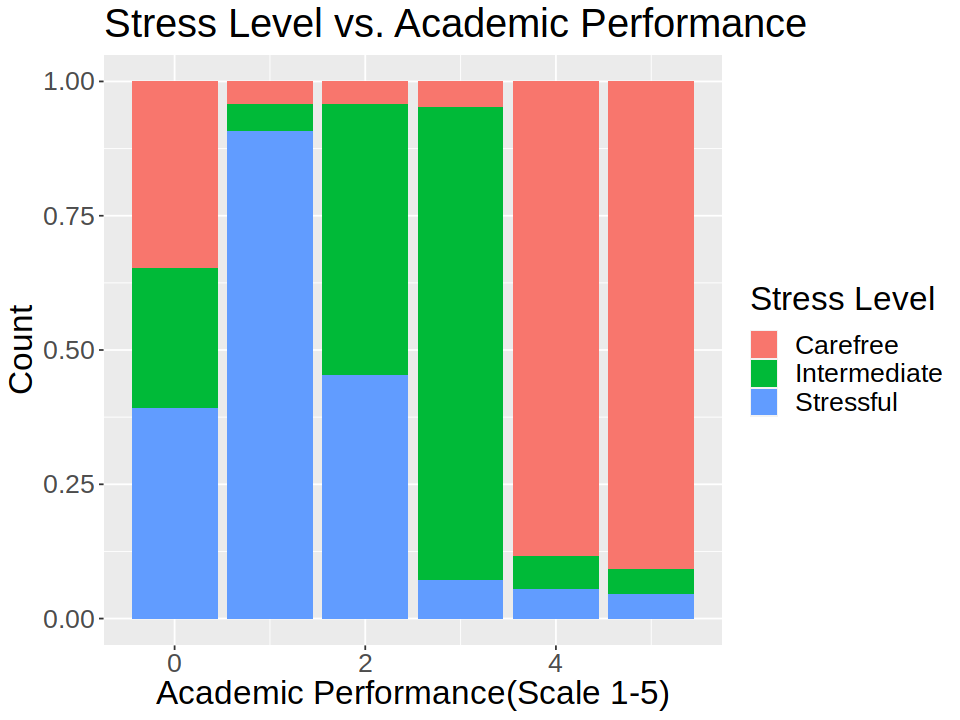

Warning message in geom_histogram(stat = "count", position = "fill"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


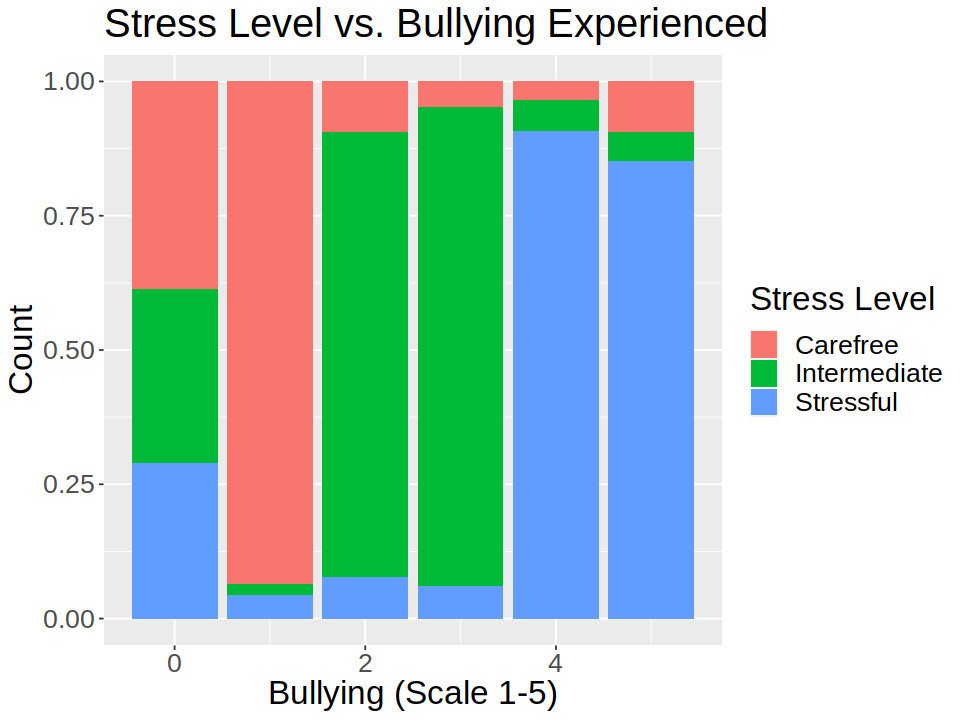

Warning message in geom_histogram(stat = "count", position = "fill"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


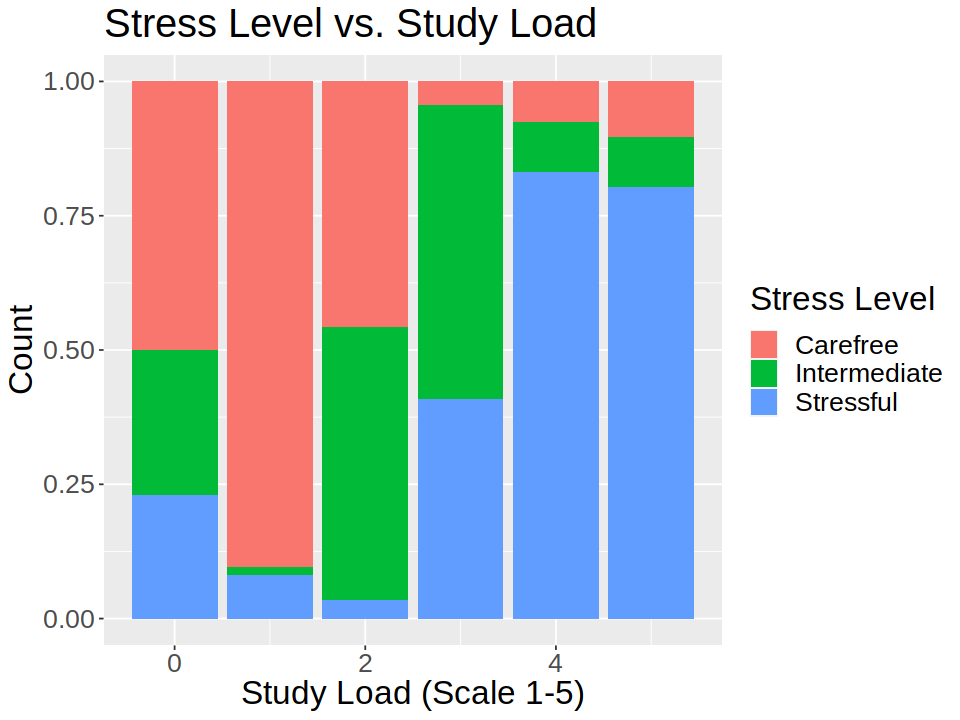

Warning message in geom_histogram(stat = "count", position = "fill"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


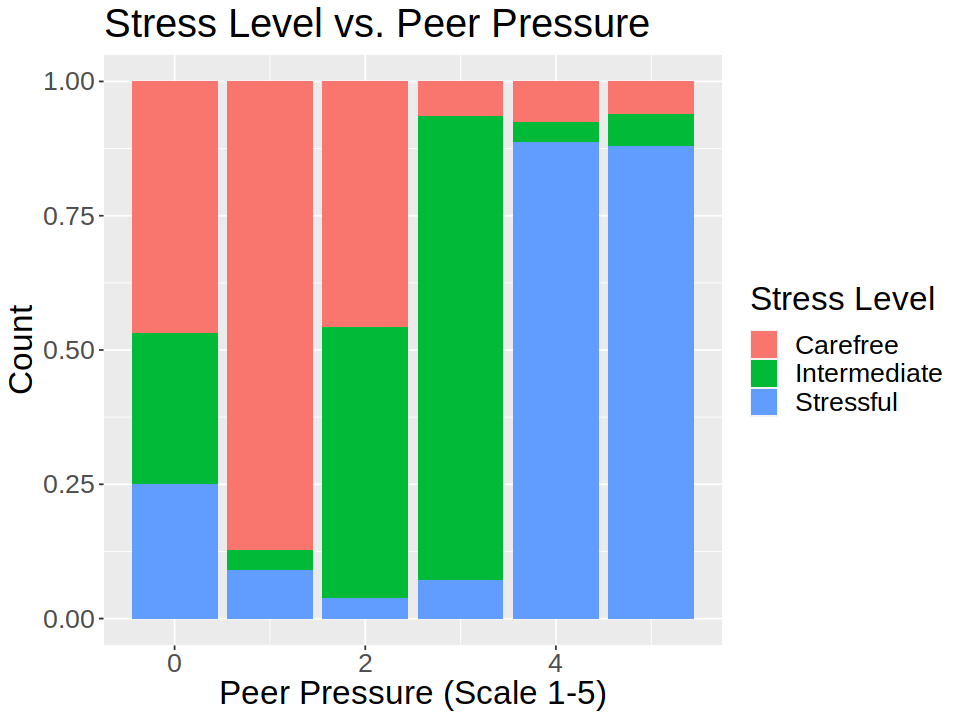

Warning message in geom_histogram(stat = "count", position = "fill"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


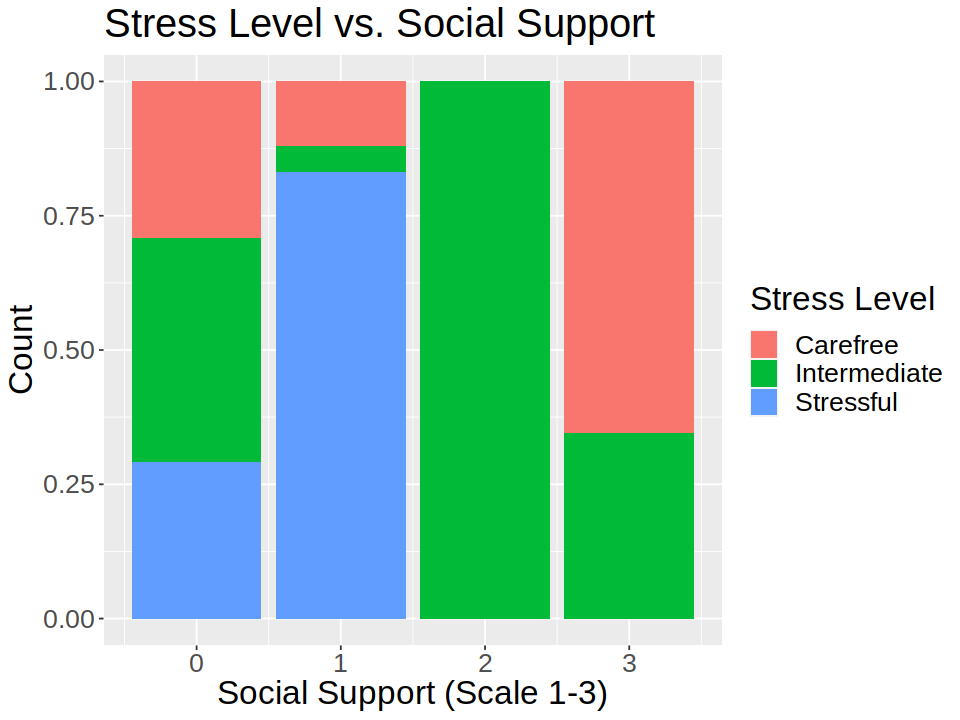

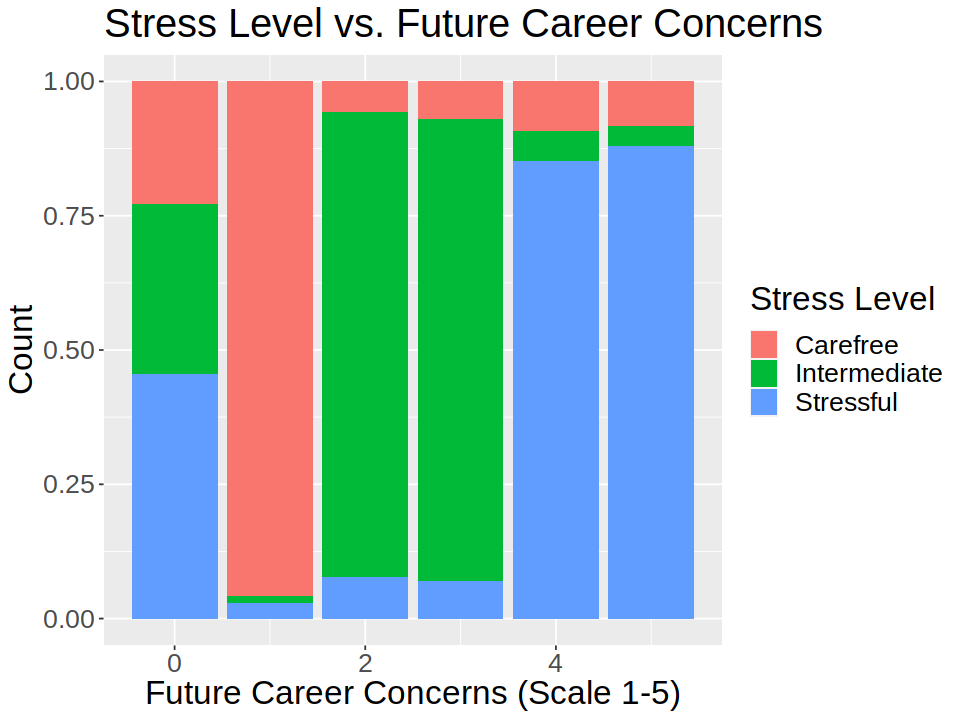

In [23]:
options(repr.plot.width = 8, repr.plot.height = 6)

stress_academic <- stress_training |>
ggplot(aes(x = academic_performance, fill = stress_level)) +
geom_histogram(stat = "count", position = "fill") +
labs(x = "Academic Performance(Scale 1-5)", y = "Count", fill = "Stress Level") +
ggtitle("Stress Level vs. Academic Performance") +
theme(text = element_text(size = 20))
stress_academic

stress_bullying <- stress_training |>
ggplot(aes(x = bullying, fill = stress_level)) +
geom_histogram(stat = "count", position = "fill") +
labs(x = "Bullying (Scale 1-5)", y = "Count", fill = "Stress Level") +
ggtitle("Stress Level vs. Bullying Experienced") +
theme(text = element_text(size = 20))
stress_bullying

stress_studyload <- stress_training |>
ggplot(aes(x = study_load, fill = stress_level)) +
geom_histogram(stat = "count", position = "fill") +
labs(x = "Study Load (Scale 1-5)", y = "Count", fill = "Stress Level") +
ggtitle("Stress Level vs. Study Load") +
theme(text = element_text(size = 20))
stress_studyload

stress_peerpressure <- stress_training |>
ggplot(aes(x = peer_pressure, fill = stress_level)) +
geom_histogram(stat = "count", position = "fill") +
labs(x = "Peer Pressure (Scale 1-5)", y = "Count", fill = "Stress Level") +
ggtitle("Stress Level vs. Peer Pressure") +
theme(text = element_text(size = 20)) 
stress_peerpressure

stress_socialsupport <- stress_training |>
ggplot(aes(x = social_support, fill = stress_level)) +
geom_histogram(stat = "count", position = "fill") +
labs(x = "Social Support (Scale 1-3)", y = "Count", fill = "Stress Level") +
ggtitle("Stress Level vs. Social Support") +
theme(text = element_text(size = 20))
stress_socialsupport

stress_future <- stress_training |>
ggplot(aes(x = future_career_concerns, fill = stress_level)) +
geom_histogram(stat = "count", position = "fill") +
labs(x = "Future Career Concerns (Scale 1-5)", y = "Count", fill = "Stress Level") +
ggtitle("Stress Level vs. Future Career Concerns") +
theme(text = element_text(size = 20))
stress_future

Methods: From the initial dataset, we'll select 7 key predictors for stress levels: academic performance, study load, teacher-student relationship, future career concerns, peer pressure, extracurricular activities, and bullying. These variables have been chosen based on their demonstrated relevance to predicting stress levels in students.
- Academic performance: This factor is pivotal as it directly reflects the student's achievements and challenges in their educational journey. Struggles or successes in academics can significantly impact stress levels, making it a critical predictor.
- Study load: The amount of coursework and assignments a student faces can be a substantial source of stress. Understanding the workload allows us to gauge how demanding their academic responsibilities are.
- Teacher-Student Relationship: A positive or strained relationship with teachers can greatly influence a student's overall experience. Supportive and constructive interactions can alleviate stress, while negative interactions may exacerbate it.
- Future Career Concerns: Students often grapple with uncertainties about their future prospects, which can be a significant stressor.
- Peer Pressure: The social dynamics and pressures among peers can be a major source of stress for students.
- Extracurricular Activities: Engaging in extracurriculars can both serve as a stress reliever or add an additional layer of responsibility, depending on the student's involvement. 
- Bullying: Experiencing or witnessing bullying can have profound effects on a student's mental and emotional well-being. It is a crucial variable to consider in understanding the sources of stress.
Given the use of multiple predictors, visualizing them on a 2D plane is not feasible.

In [ ]:
Expected Outcomes and Significance: